In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

In [3]:
bird = 'B1692'
d = 512

In [4]:
#ratings = [1,2,3]
#ratings_str = ''.join([str(x) for x in ratings])

In [5]:
#sort_path =  '/mnt/cube/srrudrar/sorted/B1596/block4/continuous/Rhythm_FPGA-100.0/'#
#
#clusters = []
#for rating in ratings:
#    x = tu.get_clusters_by_rating(sort_path, rating)
#    clusters.extend(x)
#
#n_cells = len(clusters)

In [6]:
#np.save('/mnt/cube/srrudrar/temporal_model/units_to_process_B1596.npy',clusters)

### Load dsets

In [9]:
stim_spec = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/enc_test_{}.npy'.format(bird,d,d)) ###change
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(bird,d,d))###change

In [10]:
np.shape(stim_spec), np.shape(stim_resp)

((27074, 512), (27074, 194, 32))

In [11]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [12]:
nsegbins = 32

In [13]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [14]:
np.shape(stim_mne), np.shape(resp_mne)

((27074, 512), (27074, 194))

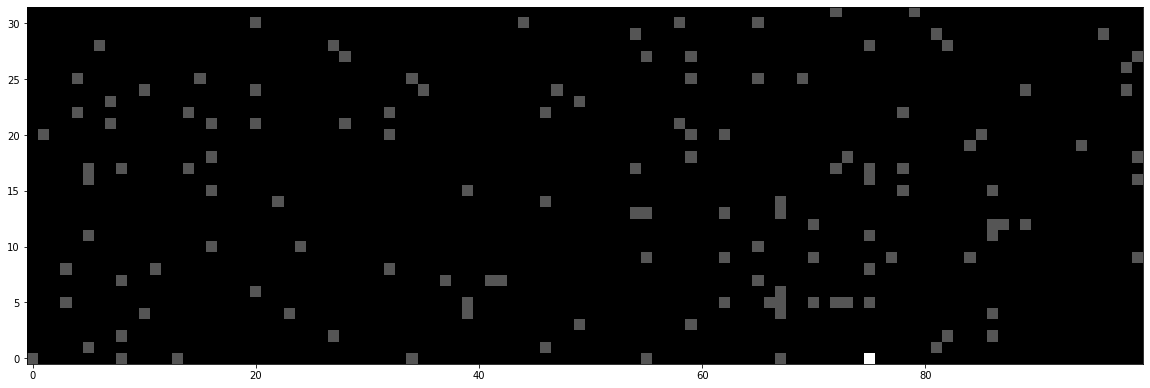

In [15]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [16]:
len_units = np.shape(resp_mne)[1]

In [18]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process_{}.npy'.format(bird)))        ###change

In [19]:
exp_path = '/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne/'.format(bird,d)           ###change

In [ ]:
# obtain all preprocessed datas

%matplotlib inline
sdim = d                                                                                                          ###change                                                                
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE

    1       0    inf


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    2       0    0.175315


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    3       0    0.175474
    4       1    0.171935
    5       0    0.172035
    6       1    0.173248
    7       2    0.173054
    8       3    0.172239
    9       4    0.172507
   10       5    0.172315
   11       6    0.173011
   12       7    0.173184
   13       8    0.172998
   14       9    0.172879
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.156823


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    2       0    0.153044


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    3       0    0.153102


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    4       1    0.152789
    5       0    0.152975
    6       1    0.152794
    7       2    0.152810
    8       3    0.152819
    9       4    0.152640
   10       0    0.152594
   11       0    0.152601
   12       1    0.152508
   13       0    0.152341
   14       0    0.152162
   15       0    0.152356
   16       1    0.152460
   17       2    0.152480
   18       3    0.152410
   19       4    0.152354
   20       5    0.152305
   21       6    0.152243
   22       7    0.152281
   23       8    0.152329
   24       9    0.152336
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.158521


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    2       0    0.156821


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    3       0    0.156686


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    4       0    0.156322
    5       0    0.155891


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/tempor

    6       0    0.155783


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    7       0    0.155713
    8       0    0.155590
    9       0    0.155571
   10       0    0.155563
   11       0    0.155529
   12       0    0.155347
   13       0    0.155344
   14       0    0.155361
   15       1    0.155484
   16       2    0.155424
   17       3    0.155267
   18       0    0.155245
   19       0    0.155080
   20       0    0.171080
   21       1    0.162916
   22       2    0.157922
   23       3    0.154966
   24       0    0.154973
   25       1    0.154908
   26       0    0.154800
   27       0    0.154769
   28       0    0.155815
   29       1    0.157505
   30       2    0.154713
   31       0    0.154648
   32       0    0.154607
   33       0    0.165853
   34       1    0.169675
   35       2    0.172372
   36       3    0.173541
   37       4    0.154503
   38       0    0.154492
   39       0    0.154475
   40       0    0.154466
   41       0    0.154443
   42       0    0.154421
   43       0    0.154840
   44       1    0.174999
   45       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.182241


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    2       0    0.201923


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/sr

    3       0    0.202788


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    4       1    0.200310
    5       0    0.194668
    6       0    0.195165
    7       1    0.200252
    8       2    0.199932
    9       3    0.202835
   10       4    0.200139
   11       5    0.196497
   12       6    0.192234
   13       0    0.188696
   14       0    0.184920
   15       0    0.183087
   16       0    0.184667
   17       1    0.184812
   18       2    0.184669
   19       3    0.184442
   20       4    0.185411
   21       5    0.185562
   22       6    0.184446
   23       7    0.184416
   24       8    0.182796
   25       0    0.181815
   26       0    0.181470
   27       0    0.181122
   28       0    0.181185
   29       1    0.181382
   30       2    0.181900
   31       3    0.181680
   32       4    0.181447
   33       5    0.181877
   34       6    0.181869
   35       7    0.182556
   36       8    0.181966
   37       9    0.181646
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129127


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


In [ ]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)